In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

# Load and visualize the audio 

### Define the test path

In [2]:
CAPUCHIN_CLIP = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-0.wav')
NOT_CAPUCHIN_CLIP = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

### Utility functions for loading audio files and making sure the sample rate is correct

In [3]:
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

### Plot the wave (test)

In [4]:
p_wav = load_wav_16k_mono(CAPUCHIN_CLIP)
n_wav = load_wav_16k_mono(NOT_CAPUCHIN_CLIP)

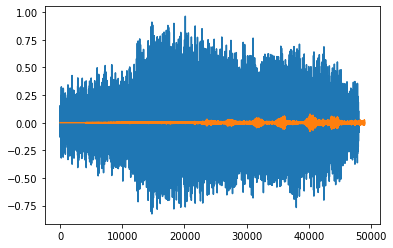

In [5]:
plt.plot(p_wav)
plt.plot(n_wav)
plt.show()

# Create the dataset

In [6]:
POS_PATH = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG_PATH = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [7]:
pos = tf.data.Dataset.list_files(POS_PATH + '/*.wav')
neg = tf.data.Dataset.list_files(NEG_PATH + '/*.wav')

### Label pos and neg as 1 and 0

In [8]:
positive_dataset = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negative_dataset = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
dataset = positive_dataset.concatenate(negative_dataset)

### Determine the avg length of the calls

In [9]:
lengths = []
for file in pos:
    tensor_wav = load_wav_16k_mono(file)
    lengths.append(len(tensor_wav))

In [10]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [11]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [12]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [13]:
# calculate mean time of the calls (the sample rate is 16khz)
avg_time = tf.math.reduce_mean(lengths)/16000
max_time = tf.math.reduce_max(lengths)/16000
min_time = tf.math.reduce_min(lengths)/16000

In [14]:
# determine the time interval we need to take
interval = 40000

# Function to convert call to a spectrogram

In [15]:
def convert_spectrogram(filename, label):
    wav = load_wav_16k_mono(filename)
    wav = wav[:interval]
    padding = tf.zeros([interval] - tf.shape(wav), dtype = tf.float32)
    wav = tf.concat([padding, wav], 0)
    spectrogram = tf.signal.stft(wav, frame_length = 320, frame_step = 32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis = 2)
    return spectrogram, label

### Plot the spectrogram (test)

In [16]:
fileneame, label = positive_dataset.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = convert_spectrogram(fileneame, label)

In [17]:
spectrogram.shape

TensorShape([1241, 257, 1])

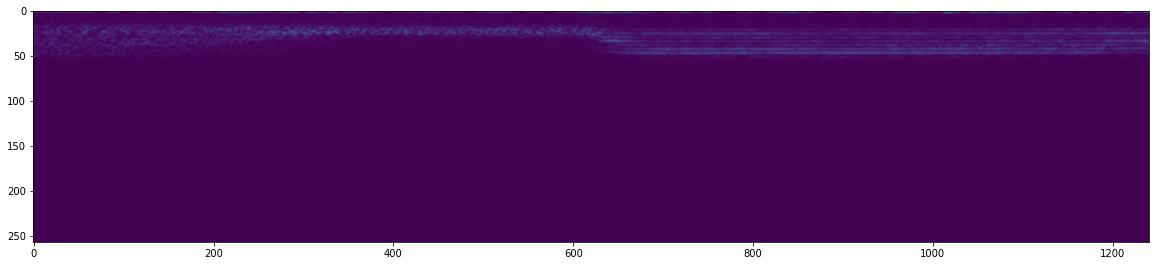

In [18]:
plt.figure(figsize = (20,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Split the datas into training set and testing set

In [19]:
dataset = dataset.map(convert_spectrogram)
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [20]:
# check the length of dataset
len(dataset)

51

In [21]:
# take 39 for training, 12 for testing
training_set = dataset.take(39)
testing_set = dataset.skip(39).take(12)

### check the size of the spectrogram of one sample

In [22]:
spectrograms, labels = training_set.as_numpy_iterator().next()

In [23]:
spectrograms.shape[1:]

(1241, 257, 1)

# Build the CNN model

In [57]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape = spectrograms.shape[1:]))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [58]:
model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1239, 255, 32)     320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 619, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 617, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 308, 62, 32)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 306, 60, 64)       18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 153, 30, 64)     

# Fit model and see the KPI Plots

In [60]:
rec = model.fit(training_set, epochs=5, validation_data=testing_set)

Epoch 1/5
39/39 [==============================] - 115s 3s/step - loss: 0.6627 - binary_accuracy: 0.9167 - precision_1: 0.8896 - recall_1: 0.7965 - val_loss: 0.0988 - val_binary_accuracy: 0.9570 - val_precision_1: 1.0000 - val_recall_1: 0.8596
Epoch 2/5
39/39 [==============================] - 108s 3s/step - loss: 0.0633 - binary_accuracy: 0.9808 - precision_1: 0.9576 - recall_1: 0.9693 - val_loss: 0.0190 - val_binary_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 3/5
39/39 [==============================] - 110s 3s/step - loss: 0.0195 - binary_accuracy: 0.9952 - precision_1: 0.9940 - recall_1: 0.9880 - val_loss: 0.0095 - val_binary_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 4/5
39/39 [==============================] - 109s 3s/step - loss: 0.0023 - binary_accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 2.9455e-04 - val_binary_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 5/5
39/39 [===

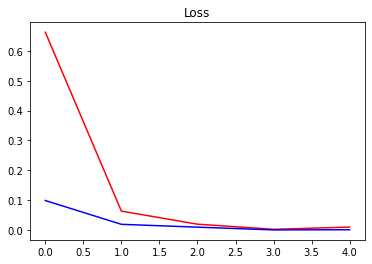

In [61]:
# plot the loss
plt.title('Loss')
plt.plot(rec.history['loss'], 'r')
plt.plot(rec.history['val_loss'], 'b')
plt.show()

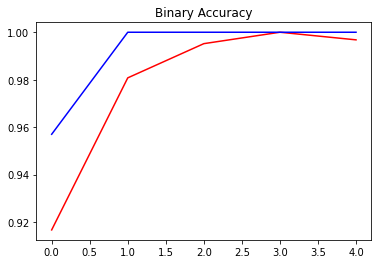

In [62]:
# plot the accuracy
plt.title('Binary Accuracy')
plt.plot(rec.history['binary_accuracy'], 'r')
plt.plot(rec.history['val_binary_accuracy'], 'b')
plt.show()

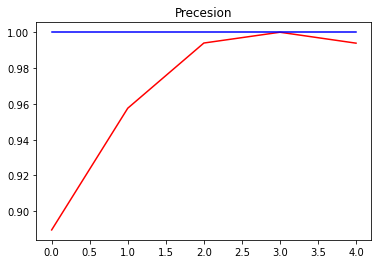

In [65]:
# plot the precession
plt.title('Precesion')
plt.plot(rec.history['precision'], 'r')
plt.plot(rec.history['val_precision'], 'b')
plt.show()

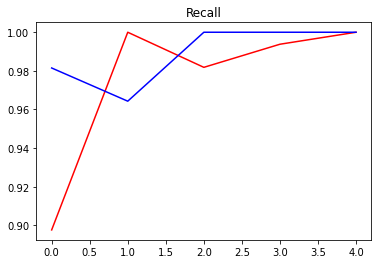

In [31]:
# plot the recall
plt.title('Recall')
plt.plot(rec.history['recall'], 'r')
plt.plot(rec.history['val_recall'], 'b')
plt.show()

# Test the prediction on one clip

In [32]:
X_test, y_test = list(testing_set.as_numpy_iterator())[0]

In [33]:
h_test = model.predict(X_test)

In [34]:
# convert the probability to binary
h_test = [1 if pred > 0.5 else 0 for pred in h_test]

### Check they are consistent

In [35]:
y_test

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
      dtype=float32)

In [36]:
h_test

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]

# Forest Parsing Function

In [37]:
# almost the same function as load_wav_16k_mono
def load_mp3_16k_mono(filename):
    """ Load an mp3 file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [38]:
mp3_path = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [39]:
mp3 = load_mp3_16k_mono(mp3_path)

In [40]:
#slice the audio ("interval" samples per slice)
audio_slices = tf.keras.utils.timeseries_dataset_from_array(mp3, mp3, sequence_length=interval, sequence_stride=interval, batch_size=1)

In [41]:
samples, indices = list(audio_slices.as_numpy_iterator())[0]

In [42]:
def convert_spectrogram_mp3(sample, index):
    sample = sample[0]
    padding = tf.zeros([interval] - tf.shape(sample), dtype = tf.float32)
    wav = tf.concat([padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length = 320, frame_step = 32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis = 2)
    return spectrogram

In [43]:
len(audio_slices)

72

In [44]:
audio_slices = audio_slices.map(convert_spectrogram_mp3)
audio_slices = audio_slices.batch(64)

In [45]:
h = model.predict(audio_slices)
h = [1 if pred > 0.9 else 0 for pred in h]

In [46]:
# check the length of hypothesis function
len(h)

72

In [47]:
# test recording_00.mp3
h

[0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

### Group the consecutive calls

In [48]:
from itertools import groupby

In [49]:
h = [key for key, group in groupby(h)]
n_calls = tf.math.reduce_sum(h).numpy()

In [50]:
n_calls

5

# Make predictions on all files

In [51]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file) 
    mp3 = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(mp3, mp3, sequence_length=interval, sequence_stride=interval, batch_size=1)
    audio_slices = audio_slices.map(convert_spectrogram_mp3)
    audio_slices = audio_slices.batch(64)
    h = model.predict(audio_slices)
    results[file] = h

In [52]:
preds = {}
for file, prob in results.items():
    preds[file] = [1 if pred > 0.99 else 0 for pred in prob]

In [53]:
preds

{'recording_00.mp3': [0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [54]:
number_of_calls = {}
for file, seg_call in preds.items():
    number_of_calls[file] = tf.math.reduce_sum([key for key, group in groupby(seg_call)]).numpy()

In [55]:
number_of_calls

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 25,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 2,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 4,
 'recording_17.mp3': 5,
 'recording_18.mp3': 1,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 13,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 11,
 'recording_29.mp3': 0,
 'recording_30.mp3': 3,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_38.mp3': 4,
 'recording_39.mp3': 14,
 'recording_40.mp3': 1,
 'recording_

# Export the CSV

In [56]:
import csv
with open('results2.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in number_of_calls.items():
        writer.writerow([key, value])